<h1>Encodings for Next Step Activity Prediction</h1>

<h5>Lorenzo Manuel Cirac Monteagudo</h5>
<h5>Supervisor: Ana Luisa Oliveira da Nobrega Costa</h5>
<h5>Chair: Information Systems</h5>
<h5>TUM School of Computation, Information and Technology</h5>

<h3>Overview</h3>
<p>Next-step activity prediction is a supervised machine learning task where you predict what activity will happen next in a business process, given the history of activities that have already occurred in a case.</p>

<h3>Dataset Information</h3>
<p>Helpdesk dataset: <a href="https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets">https://github.com/ERamaM/PredictiveMonitoringDatasets/tree/master/raw_datasets</a></p>
<p>This dataset contains events from a ticketing management process of the help desk of an Italian software company. </p>

In [1]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pm4py.objects.conversion.log import converter as xes_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

log = xes_importer.apply("data/helpdesk")
df = xes_converter.apply(log, variant=xes_converter.Variants.TO_DATA_FRAME)

parsing log, completed traces ::   0%|          | 0/4580 [00:00<?, ?it/s]

<h3>Dataset Exploration</h3>

In [3]:
df["concept:name"].unique()

array(['Assign seriousness', 'Take in charge ticket', 'Resolve ticket',
       'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket',
       'Schedule intervention', 'RESOLVED', 'INVALID', 'VERIFIED',
       'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21348 entries, 0 to 21347
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   concept:name          21348 non-null  object             
 1   lifecycle:transition  21348 non-null  object             
 2   org:resource          21348 non-null  object             
 3   time:timestamp        21348 non-null  datetime64[ns, UTC]
 4   Activity              21348 non-null  object             
 5   Resource              21348 non-null  object             
 6   case:concept:name     21348 non-null  object             
 7   case:variant          21348 non-null  object             
 8   case:variant-index    21348 non-null  int64              
 9   case:creator          21348 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(8)
memory usage: 1.6+ MB


In [5]:
print(f"Cases: {len(log)}")
print(f"Events: {sum(len(trace) for trace in log)}")
print(f"Activities: {len(pm4py.get_event_attribute_values(log, "concept:name"))}")
print(f"Variants: {len(pm4py.stats.get_variants(log))}")
print(f"Average case length: {(sum(len(trace) for trace in log) / len(log)):.2f} events per case")

# top 5 most common activities
activities = pm4py.get_event_attribute_values(log, "concept:name")
print("\nMost common activities:")
for i, (activity, count) in enumerate(sorted(activities.items(), key=lambda x: x[1], reverse=True)[:5], 1):
    print(f"{i}. {activity}: {count}")

# top 5 most common activities by position
positions = defaultdict(lambda: defaultdict(int))
for trace in log:
    for i, event in enumerate(trace):
        positions[i][event["concept:name"]] += 1
print("\nMost common by position:")
for i in range(5):
    if i in positions:
        activity, count = max(positions[i].items(), key=lambda x: x[1])
        print(f"{i+1}. {activity} ({count} cases, {count/len(log)*100:.1f}%)")

Cases: 4580
Events: 21348
Activities: 14
Variants: 226
Average case length: 4.66 events per case

Most common activities:
1. Take in charge ticket: 5060
2. Resolve ticket: 4983
3. Assign seriousness: 4938
4. Closed: 4574
5. Wait: 1463

Most common by position:
1. Assign seriousness (4384 cases, 95.7%)
2. Take in charge ticket (3712 cases, 81.0%)
3. Resolve ticket (2713 cases, 59.2%)
4. Closed (2504 cases, 54.7%)
5. Closed (1091 cases, 23.8%)


In [6]:
df.head()

,concept:name,lifecycle:transition,org:resource,time:timestamp,Activity,Resource,case:concept:name,case:variant,case:variant-index,case:creator
0,Assign seriousness,complete,Value 2,2010-01-13 08:40:25+00:00,Assign seriousness,Value 2,Case3608,Variant 33,33,Fluxicon Disco
1,Take in charge ticket,complete,Value 2,2010-01-29 08:52:27+00:00,Take in charge ticket,Value 2,Case3608,Variant 33,33,Fluxicon Disco
2,Resolve ticket,complete,Value 2,2010-01-29 08:52:34+00:00,Resolve ticket,Value 2,Case3608,Variant 33,33,Fluxicon Disco
3,Closed,complete,Value 5,2010-02-13 08:52:48+00:00,Closed,Value 5,Case3608,Variant 33,33,Fluxicon Disco
4,Closed,complete,Value 5,2010-02-13 08:52:48+00:00,Closed,Value 5,Case3608,Variant 33,33,Fluxicon Disco


In [7]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin"

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_vis
from pm4py.algo.filtering.dfg import dfg_filtering

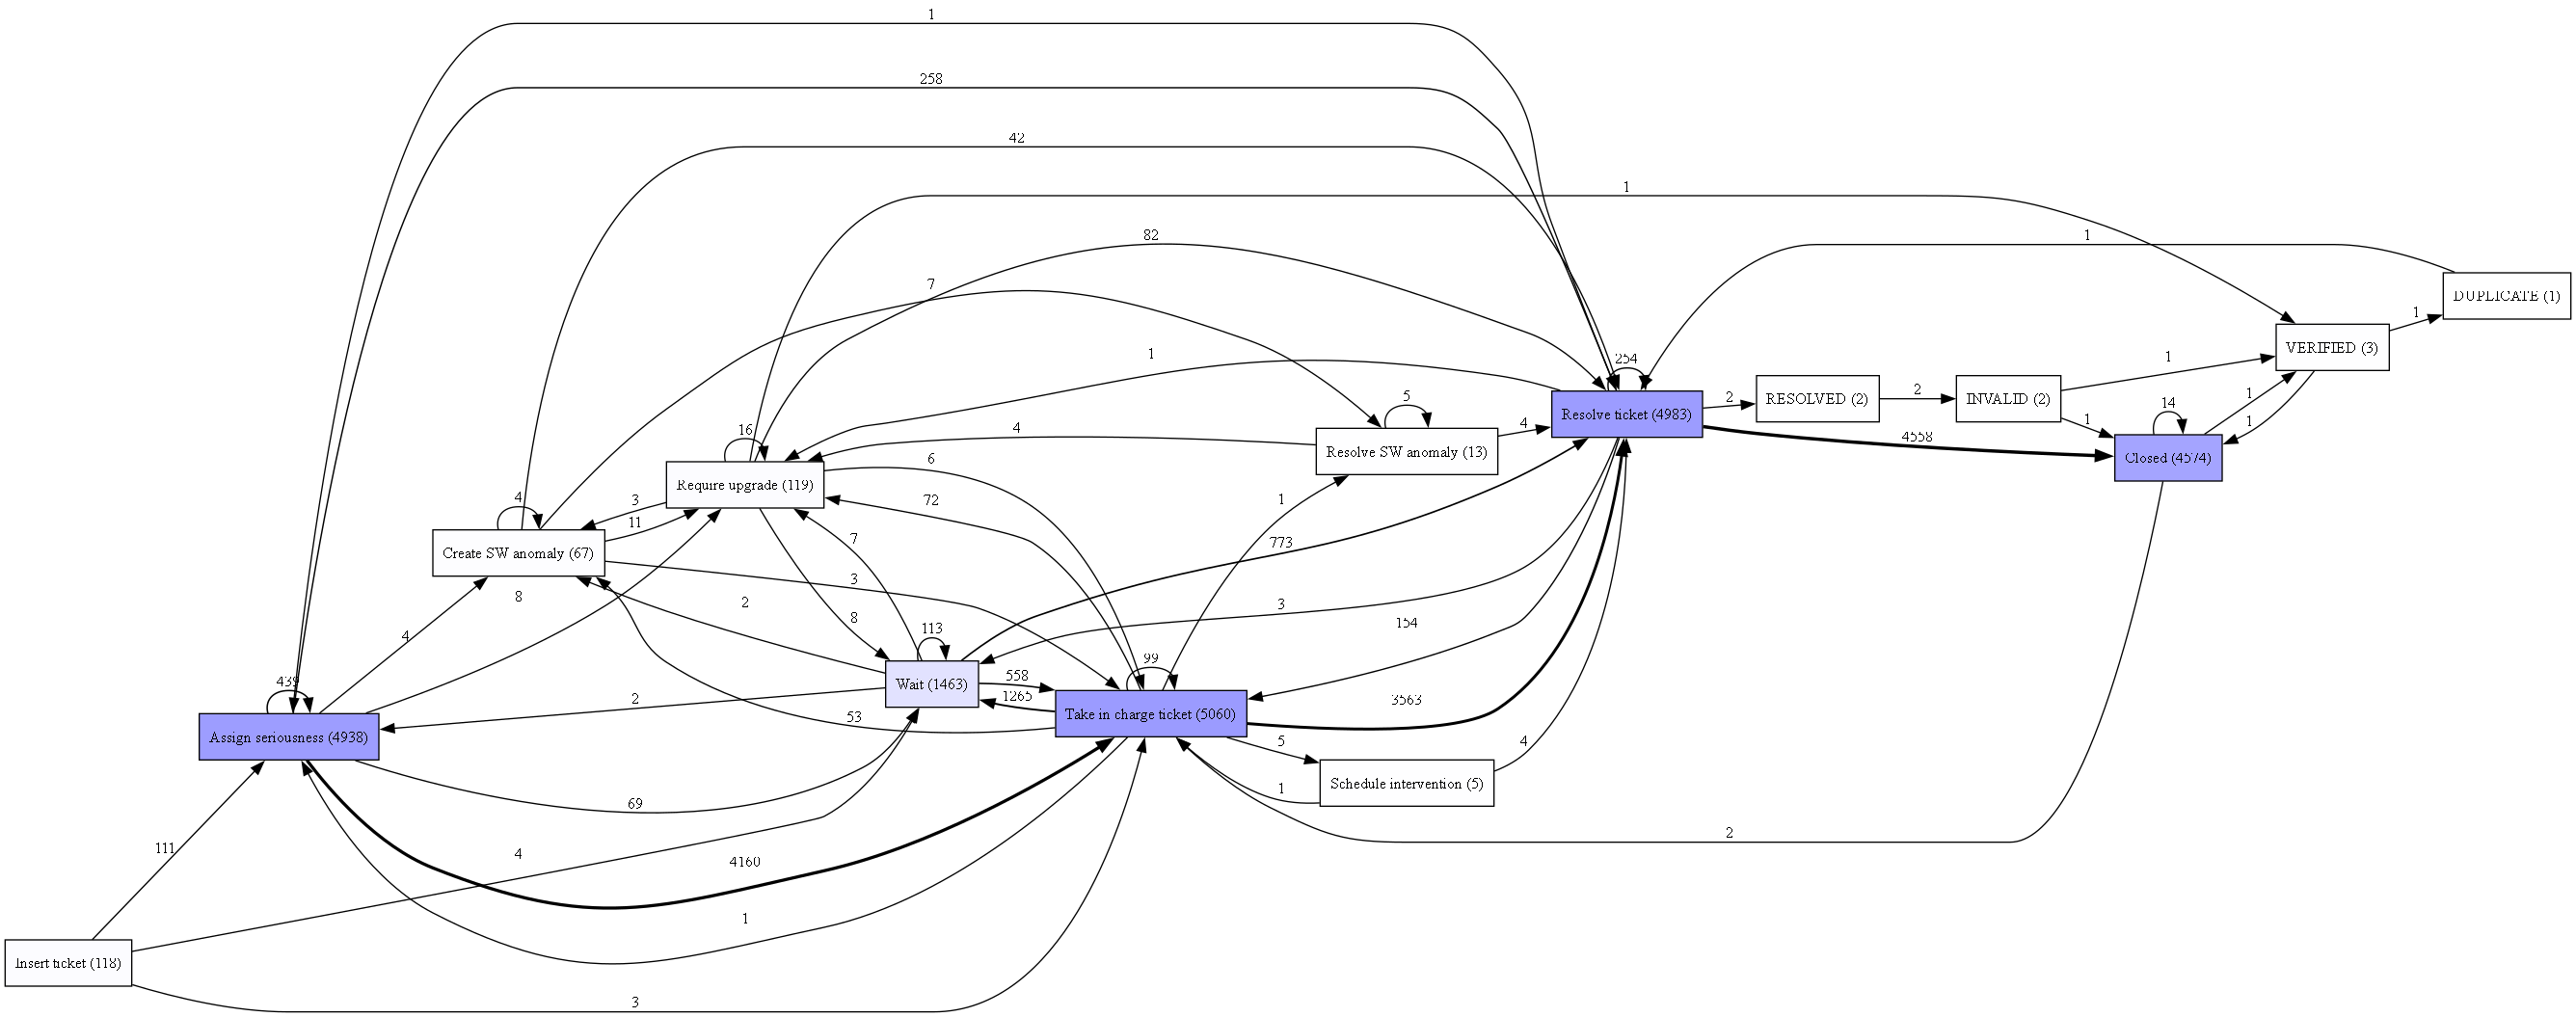

In [8]:
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.FREQUENCY)
gviz = dfg_vis.apply(dfg, log=log, variant=dfg_vis.Variants.FREQUENCY)

dfg_vis.view(gviz)

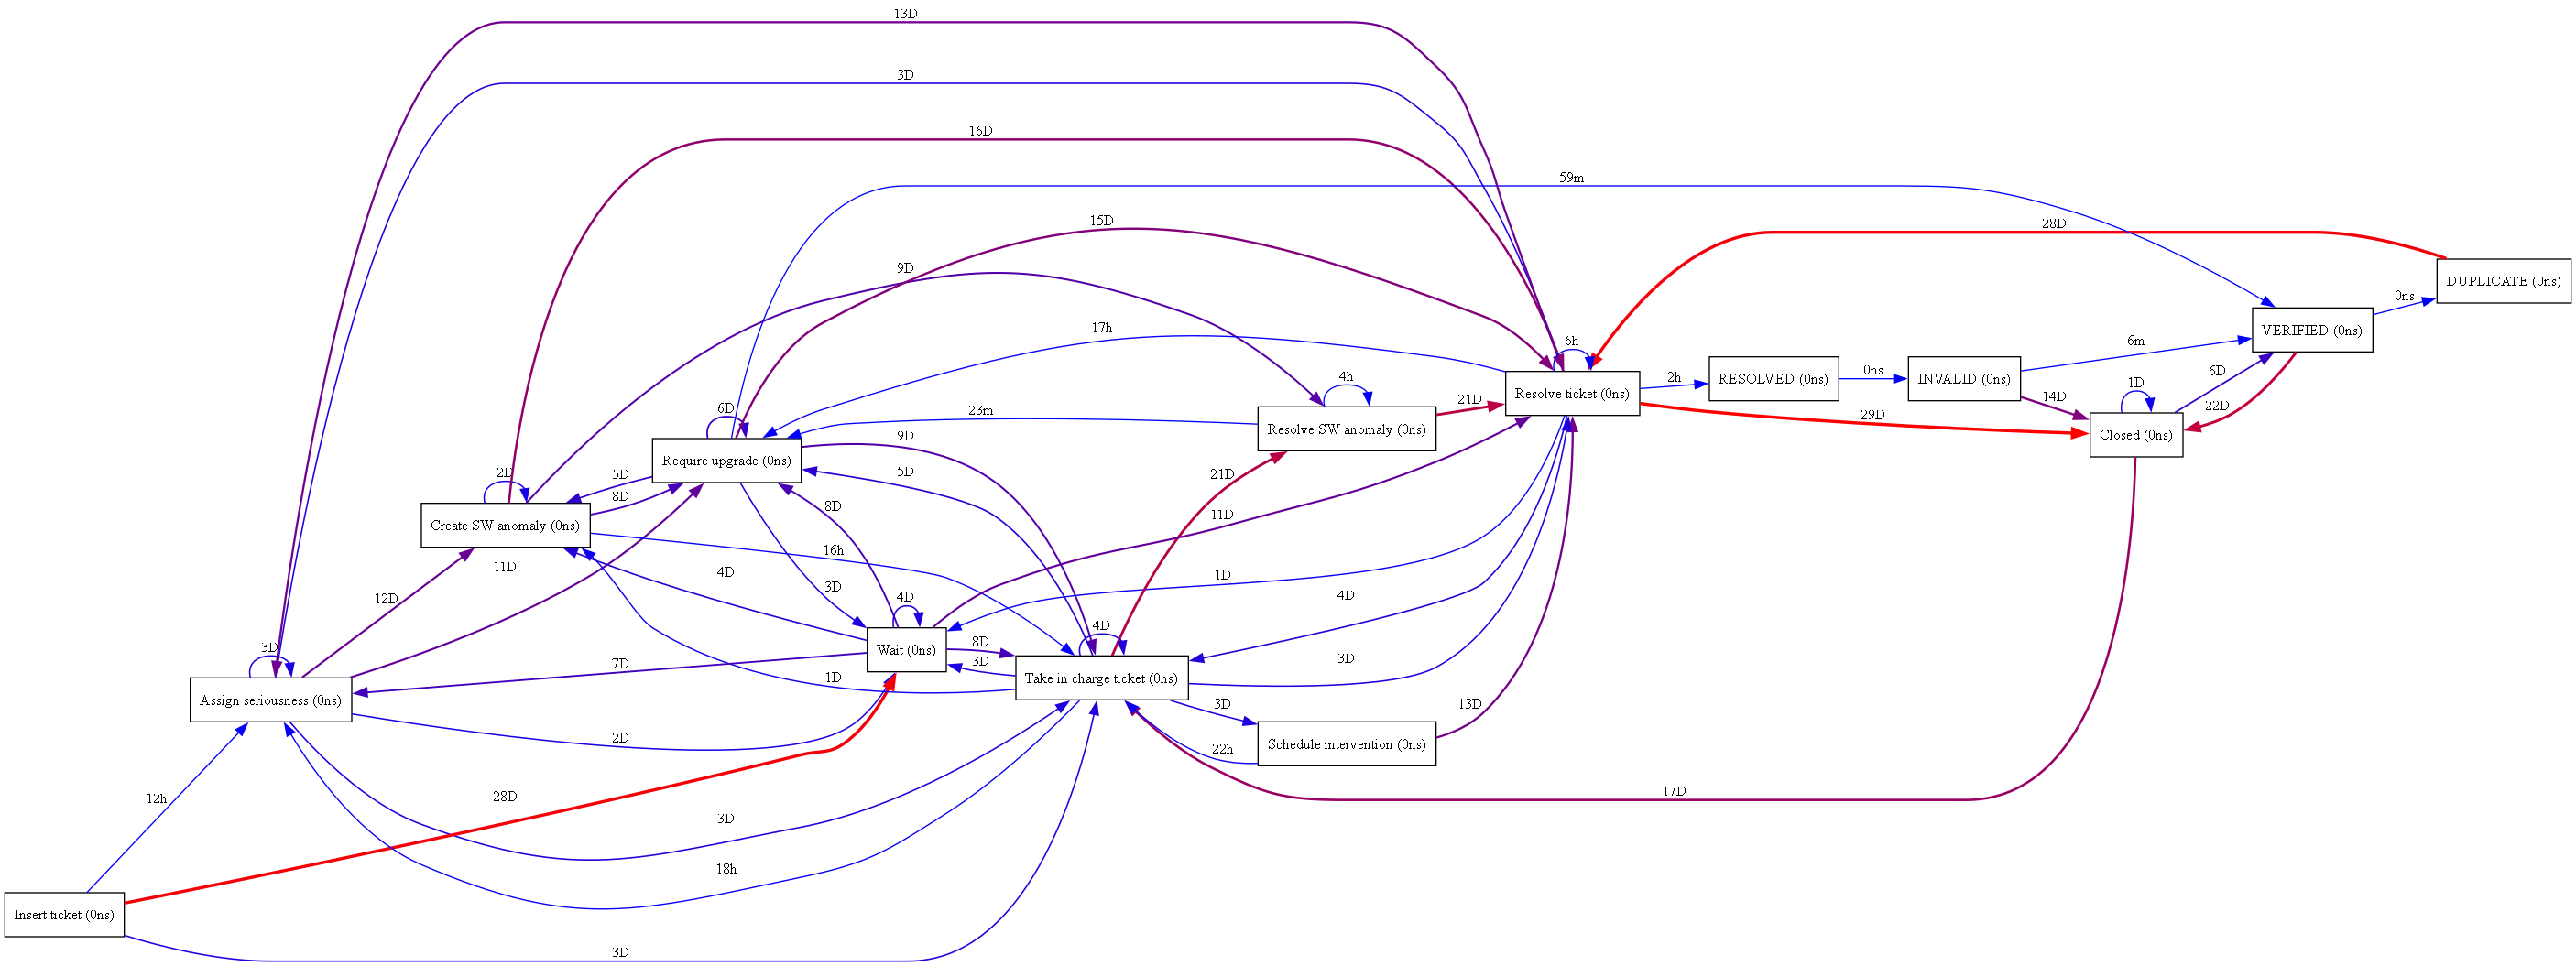

In [9]:
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_vis.apply(dfg, log=log, variant=dfg_vis.Variants.PERFORMANCE)

dfg_vis.view(gviz)

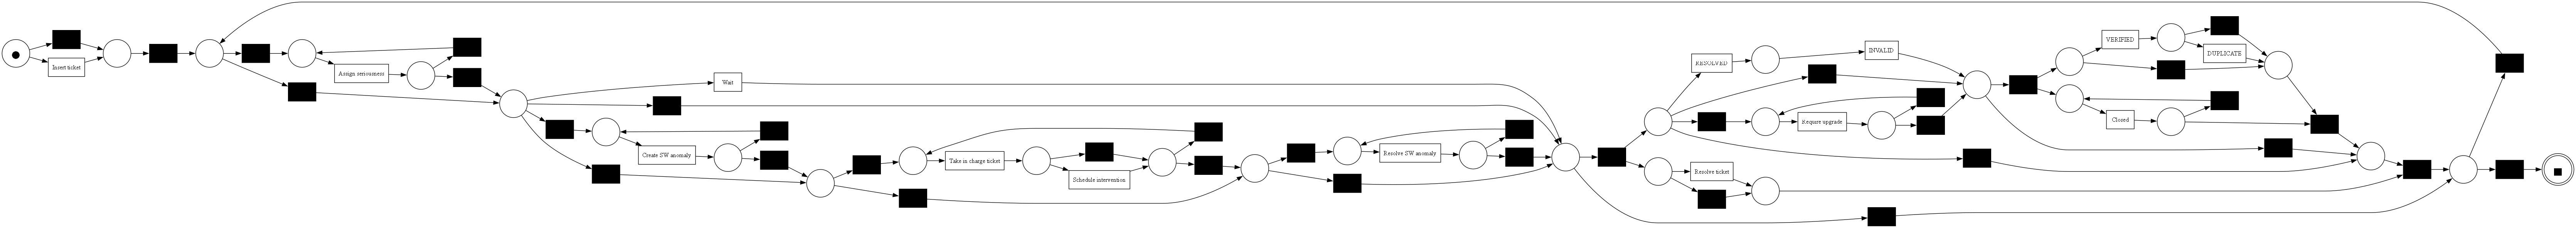

In [10]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.view_petri_net(net, initial_marking, final_marking)

<h3>Data Cleaning & Prefix Generation</h3>

In [11]:
# Clean Data
df = df.rename(columns = {
    "case:concept:name": "case_id",
    "concept:name": "activity",
    "org:resource": "resource",
    "time:timestamp": "timestamp"
})

df = df[["case_id", "activity", "resource", "timestamp"]]
df["next_activity"] = df.groupby("case_id")["activity"].shift(-1)

df = df.sort_values(by = ["case_id", "timestamp"])

df.head(10)

,case_id,activity,resource,timestamp,next_activity
17612,Case1,Assign seriousness,Value 1,2012-10-09 14:50:17+00:00,Take in charge ticket
17613,Case1,Take in charge ticket,Value 1,2012-10-09 14:51:01+00:00,Take in charge ticket
17614,Case1,Take in charge ticket,Value 2,2012-10-12 15:02:56+00:00,Resolve ticket
17615,Case1,Resolve ticket,Value 1,2012-10-25 11:54:26+00:00,Closed
17616,Case1,Closed,Value 3,2012-11-09 12:54:39+00:00,NaN
212,Case10,Assign seriousness,Value 2,2010-02-10 08:50:20+00:00,Take in charge ticket
213,Case10,Take in charge ticket,Value 2,2010-03-19 08:47:06+00:00,Resolve ticket
214,Case10,Resolve ticket,Value 2,2010-03-19 08:47:13+00:00,Closed
215,Case10,Closed,Value 5,2010-04-03 07:47:38+00:00,NaN
19330,Case100,Assign seriousness,Value 1,2013-04-12 10:25:17+00:00,Take in charge ticket


In [12]:
# Add Prefix
prefixes = []
for case_id, group in df.groupby("case_id"):
    activities = group["activity"].astype(str).tolist()
    resources = group["resource"].astype(str).tolist()
    timestamps = group["timestamp"].tolist()
    
    for i in range(1, len(activities)):   
        prefixes.append({
            "case_id": case_id,
            "step": i,
            "activities": activities[:i],
            "resources": resources[:i],
            "next_activity": activities[i],
        })

df = pd.DataFrame(prefixes)

df.head()

,case_id,step,activities,resources,next_activity
0,Case1,1,[Assign seriousness],[Value 1],Take in charge ticket
1,Case1,2,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 1]",Take in charge ticket
2,Case1,3,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2]",Resolve ticket
3,Case1,4,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2, Value 1]",Closed
4,Case10,1,[Assign seriousness],[Value 2],Take in charge ticket


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.drop(columns = ["case_id", "next_activity"])
y = df["next_activity"]

le = LabelEncoder()
y = le.fit_transform(df["next_activity"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025)

In [14]:
X

,step,activities,resources
0,1,[Assign seriousness],[Value 1]
1,2,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 1]"
2,3,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2]"
3,4,"[Assign seriousness, Take in charge ticket, Ta...","[Value 1, Value 1, Value 2, Value 1]"
4,1,[Assign seriousness],[Value 2]
...,...,...,...
16763,3,"[Assign seriousness, Take in charge ticket, Wait]","[Value 9, Value 2, Value 9]"
16764,4,"[Assign seriousness, Take in charge ticket, Wa...","[Value 9, Value 2, Value 9, Value 9]"
16765,1,[Assign seriousness],[Value 1]
16766,2,"[Assign seriousness, Take in charge ticket]","[Value 1, Value 12]"


<h3>Encodings</h3>

<h5>One Hot Encoding</h5>
<ul>
    <li>Transforms categorical sequence data into numerical features</li>
    <li>Creates binary representation where each possible category gets its own feature column</li>
    <li>Uses MultiLabelBinarizer because each sample contains multiple activities/resources lists</li>
    <li>Preserves all information about which categories are present in each sequence</li>
</ul>

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

def apply_one_hot_encoding(X_train, X_test):
    
    mlb_activities = MultiLabelBinarizer()
    mlb_resources = MultiLabelBinarizer()
    
    X_train_activities = mlb_activities.fit_transform(X_train["activities"])
    X_test_activities = mlb_activities.transform(X_test["activities"])
    
    X_train_resources = mlb_resources.fit_transform(X_train["resources"])
    X_test_resources = mlb_resources.transform(X_test["resources"])
    
    activities_columns = [f"activity_{cls}" for cls in mlb_activities.classes_]
    X_train_activities_df = pd.DataFrame(X_train_activities, columns=activities_columns, index=X_train.index)
    X_test_activities_df = pd.DataFrame(X_test_activities, columns=activities_columns, index=X_test.index)
    
    resources_columns = [f"resource_{cls}" for cls in mlb_resources.classes_]
    X_train_resources_df = pd.DataFrame(X_train_resources, columns=resources_columns, index=X_train.index)
    X_test_resources_df = pd.DataFrame(X_test_resources, columns=resources_columns, index=X_test.index)
    
    X_train_encoded = pd.concat([X_train[["step"]], X_train_activities_df, X_train_resources_df], axis=1)
    X_test_encoded = pd.concat([X_test[["step"]], X_test_activities_df, X_test_resources_df], axis=1)
    return X_train_encoded, X_test_encoded, "one-hot encoding"

In [16]:
# apply_one_hot_encoding(X_train, X_test)[0].columns.tolist()

In [17]:
apply_one_hot_encoding(X_train, X_test)[0]

,step,activity_Assign seriousness,activity_Closed,activity_Create SW anomaly,activity_DUPLICATE,activity_INVALID,activity_Insert ticket,activity_RESOLVED,activity_Require upgrade,activity_Resolve SW anomaly,...,resource_Value 20,resource_Value 21,resource_Value 22,resource_Value 3,resource_Value 4,resource_Value 5,resource_Value 6,resource_Value 7,resource_Value 8,resource_Value 9
9235,6,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2226,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4273,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1744,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1652,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16707,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15948,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11102,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<h5>Last State Encoding</h5>
<ul>
    <li>Focuses on the most recent actions in the sequence, capturing the final state before prediction (default n=3)</li>
    <li>Pads shorter sequences with "None" values to create fixed-length representation</li>
    <li>Creates positional features (last_activity_1, last_activity_2, etc.) that preserve order information</li>
    <li>Uses standard OneHotEncoder since each position now contains single categorical values instead of lists</li>
</ul>

In [18]:
from sklearn.preprocessing import OneHotEncoder

def apply_last_state_encoding(X_train, X_test, n=3):
    
    def extract_last_state(X):
        
        last_activities = X["activities"].apply(
            lambda x: (["None"] * max(0, n - len(x)) + x)[-n:]
        )
        last_resources = X["resources"].apply(
            lambda x: (["None"] * max(0, n - len(x)) + x)[-n:]
        )
        
        features = {"step": X["step"]}
        for i in range(n):
            features[f"last_activity_{i+1}"] = last_activities.apply(lambda x: x[i])
            features[f"last_resource_{i+1}"] = last_resources.apply(lambda x: x[i])
        
        return pd.DataFrame(features, index=X.index)
    
    X_train_new = extract_last_state(X_train)
    X_test_new = extract_last_state(X_test)
    
    # one hot encode
    categorical_cols = [col for col in X_train_new.columns if col != "step"]
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_encoded_array = encoder.fit_transform(X_train_new[categorical_cols])
    X_test_encoded_array = encoder.transform(X_test_new[categorical_cols])
    
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    X_train_encoded_df = pd.DataFrame(X_train_encoded_array, columns=encoded_columns, index=X_train.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded_array, columns=encoded_columns, index=X_test.index)
    
    X_train_encoded = pd.concat([X_train_new[["step"]], X_train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test_new[["step"]], X_test_encoded_df], axis=1)
    return X_train_encoded, X_test_encoded, "last_state_encoding"

In [19]:
# apply_last_state_encoding(X_train, X_test)[0].columns.tolist()

In [20]:
apply_last_state_encoding(X_train, X_test)[0]

,step,last_activity_1_Assign seriousness,last_activity_1_Closed,last_activity_1_Create SW anomaly,last_activity_1_Insert ticket,last_activity_1_None,last_activity_1_RESOLVED,last_activity_1_Require upgrade,last_activity_1_Resolve SW anomaly,last_activity_1_Resolve ticket,...,last_resource_3_Value 20,last_resource_3_Value 21,last_resource_3_Value 22,last_resource_3_Value 3,last_resource_3_Value 4,last_resource_3_Value 5,last_resource_3_Value 6,last_resource_3_Value 7,last_resource_3_Value 8,last_resource_3_Value 9
9235,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2226,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4273,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1744,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1652,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16707,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15948,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11102,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<h5>Index Encoding</h5>
<ul>
    <li>Focuses on the initial actions in the sequence, capturing early patterns and starting behaviors</li>
    <li>Extracts the first max_length elements from activity and resource sequences (default max_length=5)</li>
    <li>Pads shorter sequences with "None" values to create fixed-length representation</li>
    <li>Creates positional features (activity_1, activity_2, etc.) that preserve order information from the beginning</li>
    <li>Uses standard OneHotEncoder since each position now contains single categorical values instead of lists</li>
</ul>

In [21]:
from sklearn.preprocessing import OneHotEncoder

def apply_index_encoding(X_train, X_test, max_length=5):

    if max_length is None:
        max_length = max(X_train["activities"].apply(len).max(), 
                        X_train["resources"].apply(len).max())
        
    def extract_index_features(X):
        
        activities = X["activities"].apply(
            lambda x: (x + ["None"] * max_length)[:max_length]
        )
        resources = X["resources"].apply(
            lambda x: (x + ["None"] * max_length)[:max_length]
        )
        
        features = {"step": X["step"]}
        for i in range(max_length):
            features[f"activity_{i+1}"] = activities.apply(lambda x: x[i])
            features[f"resource_{i+1}"] = resources.apply(lambda x: x[i])
        
        return pd.DataFrame(features, index=X.index)
    
    X_train_new = extract_index_features(X_train)
    X_test_new = extract_index_features(X_test)
    
    # one hot encode
    categorical_cols = [col for col in X_train_new.columns if col != "step"]
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_encoded_array = encoder.fit_transform(X_train_new[categorical_cols])
    X_test_encoded_array = encoder.transform(X_test_new[categorical_cols])
    
    encoded_columns = encoder.get_feature_names_out(categorical_cols)
    X_train_encoded_df = pd.DataFrame(X_train_encoded_array, columns=encoded_columns, index=X_train.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded_array, columns=encoded_columns, index=X_test.index)
    
    X_train_encoded = pd.concat([X_train_new[["step"]], X_train_encoded_df], axis=1)
    X_test_encoded = pd.concat([X_test_new[["step"]], X_test_encoded_df], axis=1)
    return X_train_encoded, X_test_encoded, "index_encoding"

In [22]:
# apply_index_encoding(X_train, X_test)[0].columns.tolist()

In [23]:
apply_index_encoding(X_train, X_test)[0]

,step,activity_1_Assign seriousness,activity_1_Create SW anomaly,activity_1_Insert ticket,activity_1_Resolve ticket,activity_1_Take in charge ticket,resource_1_Value 1,resource_1_Value 10,resource_1_Value 11,resource_1_Value 12,...,resource_5_Value 20,resource_5_Value 21,resource_5_Value 22,resource_5_Value 3,resource_5_Value 4,resource_5_Value 5,resource_5_Value 6,resource_5_Value 7,resource_5_Value 8,resource_5_Value 9
9235,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2226,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4273,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1744,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1652,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16707,2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15948,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11102,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h5>Inter Case Encoding</h5>
<ul>
    <li>Combines standard one-hot encoding with cross-case statistical information</li>
    <li>Uses MultiLabelBinarizer to create binary features for activities and resources like in one-hot encoding</li>
    <li>Adds frequency features that captures how often each step appears across all training cases</li>
    <li>Provides global context about step popularity and rarity in the dataset</li>
</ul>

In [24]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def apply_inter_case_encoding(X_train, X_test):
    
    step_counts = X_train["step"].value_counts().to_dict()
    
    resource_counts = {}
    for resources_list in X_train["resources"]:
        for resource in resources_list:
            resource_counts[resource] = resource_counts.get(resource, 0) + 1
    
    mlb_activities = MultiLabelBinarizer()
    mlb_resources = MultiLabelBinarizer()
    
    X_train_activities = mlb_activities.fit_transform(X_train["activities"])
    X_test_activities = mlb_activities.transform(X_test["activities"])
    
    X_train_resources = mlb_resources.fit_transform(X_train["resources"])
    X_test_resources = mlb_resources.transform(X_test["resources"])
    
    activities_columns = [f"activity_{cls}" for cls in mlb_activities.classes_]
    X_train_activities_df = pd.DataFrame(X_train_activities, columns=activities_columns, index=X_train.index)
    X_test_activities_df = pd.DataFrame(X_test_activities, columns=activities_columns, index=X_test.index)
    resources_columns = [f"resource_{cls}" for cls in mlb_resources.classes_]
    X_train_resources_df = pd.DataFrame(X_train_resources, columns=resources_columns, index=X_train.index)
    X_test_resources_df = pd.DataFrame(X_test_resources, columns=resources_columns, index=X_test.index)
    
    # add inter case features
    X_train_step_load = X_train["step"].map(step_counts)
    X_test_step_load = X_test["step"].map(step_counts).fillna(0)
    
    X_train_avg_resource_exp = X_train["resources"].apply(
        lambda x: sum(resource_counts.get(r, 0) for r in x) / len(x) if x else 0
    )
    X_test_avg_resource_exp = X_test["resources"].apply(
        lambda x: sum(resource_counts.get(r, 0) for r in x) / len(x) if x else 0
    )
    
    X_train_step_load_df = pd.DataFrame({"step_load": X_train_step_load, "avg_resource_experience": X_train_avg_resource_exp}, index=X_train.index)
    X_test_step_load_df = pd.DataFrame({"step_load": X_test_step_load, "avg_resource_experience": X_test_avg_resource_exp}, index=X_test.index)
    
    X_train_encoded = pd.concat([
        X_train[["step"]],
        X_train_step_load_df,
        X_train_activities_df, 
        X_train_resources_df
    ], axis=1)
    X_test_encoded = pd.concat([
        X_test[["step"]],
        X_test_step_load_df,
        X_test_activities_df, 
        X_test_resources_df
    ], axis=1)
    
    return X_train_encoded, X_test_encoded, "inter_case_encoding"

In [25]:
# apply_inter_case_encoding(X_train, X_test)[0].columns.tolist()

In [26]:
apply_inter_case_encoding(X_train, X_test)[0]

,step,step_load,avg_resource_experience,activity_Assign seriousness,activity_Closed,activity_Create SW anomaly,activity_DUPLICATE,activity_INVALID,activity_Insert ticket,activity_RESOLVED,...,resource_Value 20,resource_Value 21,resource_Value 22,resource_Value 3,resource_Value 4,resource_Value 5,resource_Value 6,resource_Value 7,resource_Value 8,resource_Value 9
9235,6,268,5672.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2226,2,3637,5351.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4273,3,3488,7610.333333,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1744,3,3488,3433.666667,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1652,4,1527,6935.750000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,4,1527,5038.250000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16707,2,3637,6531.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15948,4,1527,2481.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11102,1,3654,4001.000000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<h5>Aggregation Encoding</h5>
<ul>
    <li>Creates statistical summary features instead of binary encodings</li>
    <li>Results in a compact numerical feature set that summarizes sequence characteristics</li>
</ul>

In [27]:
from collections import Counter

def apply_aggregation_encoding(X_train, X_test):
    
    def compute_aggregation_features(X):
        features = []
        for _, row in X.iterrows():
            activities = row["activities"]
            resources = row["resources"]
            
            features.append({
                "step": row["step"],
                "prefix_length": len(activities),
                "unique_activities": len(set(activities)),
                "unique_resources": len(set(resources)),
                "most_frequent_activity_count": max(Counter(activities).values()) if activities else 0,
                "most_frequent_resource_count": max(Counter(resources).values()) if resources else 0,
                "activity_resource_ratio": len(set(activities)) / len(set(resources)) if len(set(resources)) > 0 else 0
            })
        
        return pd.DataFrame(features, index=X.index)
    
    X_train_encoded = compute_aggregation_features(X_train)
    X_test_encoded = compute_aggregation_features(X_test)
    
    return X_train_encoded, X_test_encoded, "aggregation_encoding"

In [28]:
# apply_aggregation_encoding(X_train, X_test)[0].columns.tolist()

In [29]:
apply_aggregation_encoding(X_train, X_test)[0]

,step,prefix_length,unique_activities,unique_resources,most_frequent_activity_count,most_frequent_resource_count,activity_resource_ratio
9235,6,6,4,3,2,3,1.333333
2226,2,2,2,2,1,1,1.000000
4273,3,3,3,2,1,2,1.500000
1744,3,3,3,2,1,2,1.500000
1652,4,4,4,2,1,3,2.000000
...,...,...,...,...,...,...,...
5331,4,4,3,2,2,3,1.500000
16707,2,2,2,1,1,2,2.000000
15948,4,4,2,4,3,1,0.500000
11102,1,1,1,1,1,1,1.000000


<h5>Embeddings</h5>
<ul>
    <li>Treats activity and resource sequences as text documents by joining elements with spaces</li>
    <li>Uses TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to create weighted numerical features</li>
    <li>Considers both how often terms appear in individual sequences and how rare they are across the entire dataset</li>
    <li>Creates dense numerical features that capture the relative importance and discriminative power of different activities/resources</li>
    <li>Limited to top 50 features each for activities and resources to control dimensionality</li>
    <li>Results in continuous values rather than binary, where higher values indicate more important/distinctive terms</li>
</ul>

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

def apply_embedding_encoding(X_train, X_test):
    
    def lists_to_string(series):
        return series.apply(lambda x: " ".join(x))
    
    X_train_activities_str = lists_to_string(X_train["activities"])
    X_test_activities_str = lists_to_string(X_test["activities"])
    X_train_resources_str = lists_to_string(X_train["resources"])
    X_test_resources_str = lists_to_string(X_test["resources"])
    
    activity_vectorizer = TfidfVectorizer(max_features = 50)  
    resource_vectorizer = TfidfVectorizer(max_features = 50)
    X_train_activities_tfidf = activity_vectorizer.fit_transform(X_train_activities_str).toarray()
    X_test_activities_tfidf = activity_vectorizer.transform(X_test_activities_str).toarray()
    X_train_resources_tfidf = resource_vectorizer.fit_transform(X_train_resources_str).toarray()
    X_test_resources_tfidf = resource_vectorizer.transform(X_test_resources_str).toarray()
    
    activity_columns = [f"activity_{feat}" for feat in activity_vectorizer.get_feature_names_out()]
    resource_columns = [f"resource_{feat}" for feat in resource_vectorizer.get_feature_names_out()]
    
    X_train_activities_df = pd.DataFrame(X_train_activities_tfidf, columns=activity_columns, index=X_train.index)
    X_test_activities_df = pd.DataFrame(X_test_activities_tfidf, columns=activity_columns, index=X_test.index)
    X_train_resources_df = pd.DataFrame(X_train_resources_tfidf, columns=resource_columns, index=X_train.index)
    X_test_resources_df = pd.DataFrame(X_test_resources_tfidf, columns=resource_columns, index=X_test.index)
    
    X_train_encoded = pd.concat([
        X_train[["step"]],
        X_train_activities_df,
        X_train_resources_df
    ], axis=1)
    
    X_test_encoded = pd.concat([
        X_test[["step"]],
        X_test_activities_df,
        X_test_resources_df
    ], axis=1)
    
    return X_train_encoded, X_test_encoded, "embedding_encoding"

In [31]:
# apply_embedding_encoding(X_train, X_test)[0].columns.tolist()

In [32]:
apply_embedding_encoding(X_train, X_test)[0]

,step,activity_anomaly,activity_assign,activity_charge,activity_closed,activity_create,activity_duplicate,activity_in,activity_insert,activity_intervention,...,resource_14,resource_15,resource_16,resource_17,resource_18,resource_19,resource_20,resource_21,resource_22,resource_value
9235,6,0.0,0.119274,0.327399,0.0,0.0,0.0,0.327399,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.889201
2226,2,0.0,0.326410,0.447986,0.0,0.0,0.0,0.447986,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.543717
4273,3,0.0,0.229356,0.314783,0.0,0.0,0.0,0.314783,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1744,3,0.0,0.251580,0.345285,0.0,0.0,0.0,0.345285,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1652,4,0.0,0.198326,0.272196,0.0,0.0,0.0,0.272196,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,4,0.0,0.162313,0.445538,0.0,0.0,0.0,0.445538,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
16707,2,0.0,0.000000,0.332775,0.0,0.0,0.0,0.332775,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
15948,4,0.0,0.595423,0.272399,0.0,0.0,0.0,0.272399,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.522054
11102,1,0.0,0.707107,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


<h3>Random Forest Model</h3>

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

results = []

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

encodings = [
    apply_one_hot_encoding, 
    apply_last_state_encoding,
    apply_index_encoding,
    apply_inter_case_encoding,
    apply_aggregation_encoding, 
    apply_embedding_encoding
]

for encoding in encodings:
    
    X_train_encoded, X_test_encoded, method = encoding(X_train, X_test)
    
    rf = RandomForestClassifier(random_state=2025)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1)
    grid_search.fit(X_train_encoded, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_encoded)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(method)
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print()
    
    results.append({
        "encoding": method,
        "best_params": grid_search.best_params_,
        "model": best_model,
        "accuracy": accuracy,
        "f1_score": f1
    })

one-hot encoding
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.7934
F1-Score: 0.7542

last_state_encoding
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8083
F1-Score: 0.7701

index_encoding
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.7901
F1-Score: 0.7585

inter_case_encoding
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.7925
F1-Score: 0.7531

aggregation_encoding
Best Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.6857
F1-Score: 0.6382

embedding_encoding
Best Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.7916
F1-Score: 0.7566



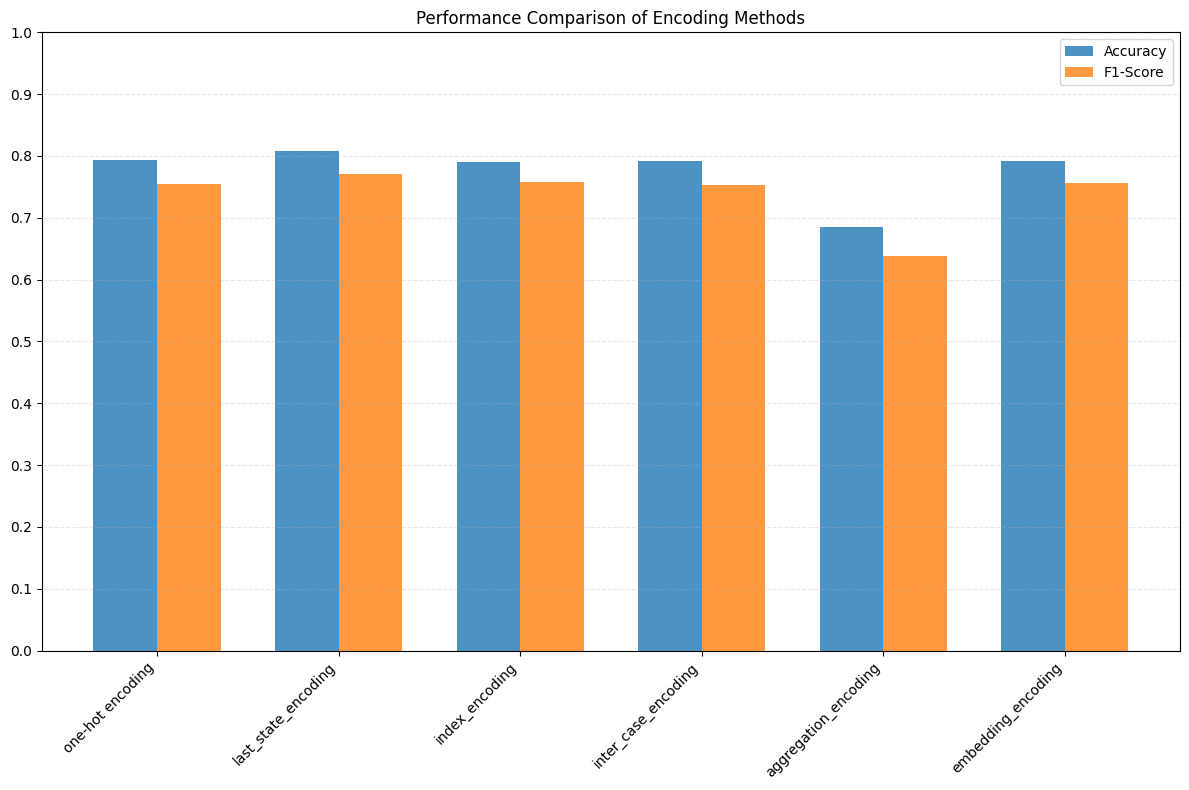

In [34]:
encodings = [result["encoding"] for result in results]
accuracies = [result["accuracy"] for result in results]
f1_scores = [result["f1_score"] for result in results]

x = np.arange(len(encodings))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, accuracies, width, label="Accuracy", alpha=0.8)
bars2 = ax.bar(x + width/2, f1_scores, width, label="F1-Score", alpha=0.8)

ax.set_title("Performance Comparison of Encoding Methods")
ax.set_xticks(x)
ax.set_xticklabels(encodings, rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()